In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.optimize as sco
import json

In [2]:
tickers = ['AMZN', 'BA', 'CAT', 'GOOGL', 'GS', 'NKE', 'NVDA', 'SOFI', 'TSLA', 'UNH']

In [3]:
# Parameters
train_start = "2023-11-17"
test_start = "2024-03-01"
test_end = "2025-01-16"
initial_capital = 50000
lookback_days = 60

# Download both Close and Open prices to obtain the desired weights for each month
data = yf.download(tickers, start=train_start, end=test_end, progress=False)
close = data['Close'].dropna()
openp = data['Open'].dropna()

# Log returns (from close prices)
log_returns = np.log(close / close.shift(1)).dropna()

# Generate monthly rebalance dates starting from test_start
rebalance_dates = pd.date_range(start=test_start, end=test_end, freq='MS')  # Month Start

# Map to actual trading days (forward-fill if it's not a trading day)
rebalance_dates = [close.index[close.index.get_indexer([d], method='bfill')[0]] for d in rebalance_dates]

# Init
weights_per_month = {}
shares_held = pd.Series(0, index=tickers)

for date in rebalance_dates:
    # Ensure date exists in index
    if date not in close.index:
        date = close.index[close.index.get_indexer([date], method='bfill')[0]]
    
    end_idx = close.index.get_loc(date)
    start_idx = end_idx - lookback_days
    if start_idx < 0:
        continue

    # Get past data window (only up to yesterday)
    window_returns = log_returns.iloc[start_idx:end_idx]
    mean_returns = window_returns.mean() * 252
    cov_matrix = window_returns.cov() * 252

    # Define Return optimizer
    def neg_return(weights):
        port_return = np.dot(weights, mean_returns.values)
        return -port_return

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0.02, 0.7)] * len(tickers)
    bounds[-4] = (0.2, 0.7) # put more weights on NVDA
    bounds[-2] = (0.4, 0.8) # put more weights on TSLA
    init_guess = np.array([1 / len(tickers)] * len(tickers))
    result = sco.minimize(neg_return, init_guess, method='SLSQP',
                          bounds=bounds, constraints=constraints)
    if not result.success:
        continue

    weights = pd.Series(result.x, index=tickers)

    # Log weights
    weights_per_month[pd.to_datetime(date).strftime("%Y-%m-%d")] = weights.round(4).to_dict()
    
# Weights per Month
print(" Diversified Weights per Month:")
print(json.dumps(weights_per_month, indent=2))


YF.download() has changed argument auto_adjust default to True
 Diversified Weights per Month:
{
  "2024-03-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-04-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-05-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-06-03": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.26,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.2,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-07-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
   

In [4]:
predictions = {}
for stock in tickers:
    predictions[stock] = pd.read_csv('Predictions of ' + stock + '.csv', parse_dates=True, index_col=0)
    
def calculate_portfolio_daily_report():
    """
    Computes a daily portfolio value report for the test period (from 2024-03-01 to 2025-01-16)
    using the following methodology:
    
    1. On the first test day (or the next available trading day if 2024-03-01 isn't in the data),
       allocate the current portfolio value according to the weights provided for that period.
    2. For each day in the period until the next rebalancing date, update each stock's 
       allocated capital using the ratio of its predicted cumulative return on that day to the
       cumulative return at the period's start.
    3. On each day, the total portfolio value is computed by summing all per-stock values plus any
       uninvested capital.
    4. At each rebalancing day (adjusted to an actual trading day), the portfolio value is updated,
       and new allocations are made for the next period.
    
    This function returns a DataFrame indexed by day with detailed portfolio values.
    """
    portfolio_value = initial_capital
    rebalance_dates_sorted = list(weights_per_month.keys())
    daily_records = []
    
    # Index of trading dates from 1 March 2024 until 16 January 2025
    pred_index = pd.to_datetime(predictions[tickers[0]].index)
    
    for i in range(len(rebalance_dates_sorted)):
        # Convert the desired rebalance date to datetime and adjust to the next trading day if needed.
        desired_start = pd.to_datetime(rebalance_dates_sorted[i])
        period_start = pred_index[pred_index.get_indexer([desired_start], method='bfill')[0]]
        
        # Determine the desired period end: if it's the last period, set to test_end; otherwise, next rebalance date.
        if i == len(rebalance_dates_sorted) - 1:
            desired_end = pd.to_datetime('2025-01-16')
        else:
            desired_end = pd.to_datetime(rebalance_dates_sorted[i+1])
        period_end = pred_index[pred_index.get_indexer([desired_end], method='bfill')[0]]
        
        # Create a daily date range for the current rebalancing period (using calendar days)
        period_days = pd.date_range(start=period_start, end=period_end, freq='D')
        
        # Get the weights for this period and compute initial allocation for each stock.
        weights = weights_per_month[rebalance_dates_sorted[i]]
        allocated_capital = {stock: weights[stock] * portfolio_value for stock in tickers}
        
        for d in period_days:
            day_stock_values = {}
            # For each stock, update the value using its predicted cumulative return
            for stock in tickers:
                # We adjust 'd' to the next available trading day if not present in predictions.
                try:
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d]
                except KeyError:
                    available_dates = pd.to_datetime(predictions[stock].index)
                    d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d_adjusted]
                    
                # Get the cumulative return at the period start
                cum_return_start = predictions[stock]['Cumulative_Return_Strategy'].loc[period_start]
                
                # Compute the multiplicative growth factor for the day
                factor = cum_return_day / cum_return_start
                
                day_stock_values[stock] = allocated_capital[stock] * factor
            
            # Total Portfolio Value after a day
            daily_total = sum(day_stock_values.values())
            
            record = {'Date': d,
                      'Total_Portfolio_Value': daily_total}
            
            for stock in tickers:
                record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)
                
            daily_records.append(record)
        
        # At the end of the period, update the portfolio value for the next period.
        portfolio_value = daily_records[-1]['Total_Portfolio_Value']
    
    df_daily_report = pd.DataFrame(daily_records).set_index('Date')
    return df_daily_report

# Generate and display the daily portfolio report.
portfolio_daily_report = calculate_portfolio_daily_report()
display("Portfolio Daily Report", portfolio_daily_report)
portfolio_daily_report.to_csv("portfolio_daily_report.csv")

'Portfolio Daily Report'

,Total_Portfolio_Value,AMZN_Value,BA_Value,CAT_Value,GOOGL_Value,GS_Value,NKE_Value,NVDA_Value,SOFI_Value,TSLA_Value,UNH_Value
Date,,,,,,,,,,,
2024-03-01,50000.000000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,22000.0000,1000.0000,20000.0000,1000.0000
2024-03-02,49613.489688,1001.7955,998.6527,1005.7914,972.3641,1010.6931,1011.6858,21604.5407,1023.6140,20000.0000,984.3523
2024-03-03,49613.489688,1001.7955,998.6527,1005.7914,972.3641,1010.6931,1011.6858,21604.5407,1023.6140,20000.0000,984.3523
2024-03-04,49613.489688,1001.7955,998.6527,1005.7914,972.3641,1010.6931,1011.6858,21604.5407,1023.6140,20000.0000,984.3523
2024-03-05,49609.240032,1011.5551,997.1621,990.5850,967.4057,1007.2404,1017.9949,21511.8951,1112.0201,20000.0000,993.3816
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,112755.094546,2334.7726,2285.2454,2305.5114,2346.0122,2247.6431,2352.1275,23631.1732,27982.1181,44977.1924,2293.2987
2025-01-13,112755.094546,2334.7726,2285.2454,2305.5114,2346.0122,2247.6431,2352.1275,23631.1732,27982.1181,44977.1924,2293.2987
2025-01-14,114257.440238,2338.5132,2309.4041,2363.1968,2329.4314,2281.8998,2367.1173,23761.5412,28837.2936,45364.7257,2304.3172


In [5]:
def calculate_equally_weighted_portfolio_report():
    portfolio_value = initial_capital
    rebalance_dates_sorted = list(weights_per_month.keys())
    daily_records = []
    
    # Index of trading dates from 1 March 2024 until 16 January 2025
    pred_index = pd.to_datetime(predictions[tickers[0]].index)

    for i in range(len(rebalance_dates_sorted)):
        desired_start = pd.to_datetime(rebalance_dates_sorted[i])
        period_start = pred_index[pred_index.get_indexer([desired_start], method='bfill')[0]]
        
        if i == len(rebalance_dates_sorted) - 1:
            desired_end = pd.to_datetime('2025-01-16')
        else:
            desired_end = pd.to_datetime(rebalance_dates_sorted[i + 1])
        period_end = pred_index[pred_index.get_indexer([desired_end], method='bfill')[0]]
        
        # Create a daily date range for the current rebalancing period (using calendar days)
        period_days = pd.date_range(start=period_start, end=period_end, freq='D')
        
        # Equally weighted portfolio
        equal_weight = 1.0 / len(tickers)
        allocated_capital = {stock: equal_weight * portfolio_value for stock in tickers}
        
        for d in period_days:
            day_stock_values = {}
            # For each stock, update the value using its predicted cumulative return
            for stock in tickers:
                try:
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d]
                except KeyError:
                    available_dates = pd.to_datetime(predictions[stock].index)
                    d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d_adjusted]
                
                # Get the cumulative return at the period start
                cum_return_start = predictions[stock]['Cumulative_Return_Strategy'].loc[period_start]
                
                # Compute the multiplicative growth factor for the day
                factor = cum_return_day / cum_return_start
                day_stock_values[stock] = allocated_capital[stock] * factor
            
            # Total Portfolio Value after a day
            daily_total = sum(day_stock_values.values())
            
            record = {'Date': d, 'Total_Portfolio_Value': daily_total}
            for stock in tickers:
                record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)
            
            daily_records.append(record)
        
        # At the end of the period, update the portfolio value for the next period.
        portfolio_value = daily_records[-1]['Total_Portfolio_Value']

    df_daily_report = pd.DataFrame(daily_records).set_index('Date')
    return df_daily_report

# Generate and display the daily equally weighted portfolio report.
equally_weighted_report = calculate_equally_weighted_portfolio_report()
display("Equally Weighted Portfolio Daily Report", equally_weighted_report)
equally_weighted_report.to_csv("equally_weighted_portfolio_report.csv")


'Equally Weighted Portfolio Daily Report'

,Total_Portfolio_Value,AMZN_Value,BA_Value,CAT_Value,GOOGL_Value,GS_Value,NKE_Value,NVDA_Value,SOFI_Value,TSLA_Value,UNH_Value
Date,,,,,,,,,,,
2024-03-01,50000.000000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
2024-03-02,49954.867727,5008.9777,4993.2637,5028.9568,4861.8207,5053.4657,5058.4289,4910.1229,5118.0698,5000.0000,4921.7616
2024-03-03,49954.867727,5008.9777,4993.2637,5028.9568,4861.8207,5053.4657,5058.4289,4910.1229,5118.0698,5000.0000,4921.7616
2024-03-04,49954.867727,5008.9777,4993.2637,5028.9568,4861.8207,5053.4657,5058.4289,4910.1229,5118.0698,5000.0000,4921.7616
2024-03-05,50375.791625,5057.7757,4985.8106,4952.9251,4837.0283,5036.2018,5089.9747,4889.0671,5560.1005,5000.0000,4966.9079
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,84995.800938,8654.7761,8471.1836,8546.3075,8696.4403,8331.7953,8719.1090,8759.8473,7979.0003,8336.3050,8501.0365
2025-01-13,84995.800938,8654.7761,8471.1836,8546.3075,8696.4403,8331.7953,8719.1090,8759.8473,7979.0003,8336.3050,8501.0365
2025-01-14,85838.992266,8668.6423,8560.7376,8760.1419,8634.9770,8458.7816,8774.6747,8808.1734,8222.8506,8408.1324,8541.8808


In [6]:
def calculate_equally_weighted_buy_and_hold_daily_report():
    portfolio_value = initial_capital
    daily_records = []
    
    # Index of trading dates from 1 March 2024 until 16 January 2025
    pred_index = pd.to_datetime(predictions[tickers[0]].index)

    # Start and end of test period
    start_date = pd.to_datetime('2024-03-01')
    end_date = pd.to_datetime('2025-01-16')
    test_start = pred_index[pred_index.get_indexer([start_date], method='bfill')[0]]
    test_end = pred_index[pred_index.get_indexer([end_date], method='bfill')[0]]
    test_days = pd.date_range(start=test_start, end=test_end, freq='D')

    # Get start close price for each stock
    start_close = {}
    for stock in tickers:
        start_close[stock] = predictions[stock]['Close'].loc[test_start]

    capital_per_stock = portfolio_value / len(tickers)

    for d in test_days:
        day_stock_values = {}
        for stock in tickers:
            try:
                close_today = predictions[stock]['Close'].loc[d]
            except KeyError:
                available_dates = pd.to_datetime(predictions[stock].index)
                d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                close_today = predictions[stock]['Close'].loc[d_adjusted]
            
            # Compute the multiplicative growth factor for the day
            growth = close_today / start_close[stock]
            day_stock_values[stock] = capital_per_stock * growth

        # Total Portfolio Value after a day
        daily_total = sum(day_stock_values.values())
        record = {'Date': d, 'Total_Portfolio_Value': daily_total}

        for stock in tickers:
            record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)

        daily_records.append(record)

    df_buy_hold = pd.DataFrame(daily_records).set_index('Date')
    return df_buy_hold

# Generate and export the Buy-and-Hold daily portfolio report
equally_weighted_buy_and_hold_report = calculate_equally_weighted_buy_and_hold_daily_report()
display("Equally Weighted Buy and Hold Daily Report", equally_weighted_buy_and_hold_report)
equally_weighted_buy_and_hold_report.to_csv("equally_weighted_buy_and_hold_daily_report.csv")


'Equally Weighted Buy and Hold Daily Report'

,Total_Portfolio_Value,AMZN_Value,BA_Value,CAT_Value,GOOGL_Value,GS_Value,NKE_Value,NVDA_Value,SOFI_Value,TSLA_Value,UNH_Value
Date,,,,,,,,,,,
2024-03-01,50000.000000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
2024-03-02,49340.654241,4982.0447,5013.4998,5028.9568,4861.8207,5053.4657,4885.1591,5179.7542,4771.9689,4642.2227,4921.7616
2024-03-03,49340.654241,4982.0447,5013.4998,5028.9568,4861.8207,5053.4657,4885.1591,5179.7542,4771.9689,4642.2227,4921.7616
2024-03-04,49340.654241,4982.0447,5013.4998,5028.9568,4861.8207,5053.4657,4885.1591,5179.7542,4771.9689,4642.2227,4921.7616
2024-03-05,48124.311951,4884.9735,5028.5000,4952.9251,4837.0283,5036.2018,4824.7940,5224.1783,4043.3816,4459.6330,4832.6963
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,65277.118401,6128.9419,4264.2502,5444.2463,6989.2971,7376.0584,3585.3670,8098.5290,7825.3615,9951.3916,5613.6754
2025-01-13,65277.118401,6128.9419,4264.2502,5444.2463,6989.2971,7376.0584,3585.3670,8098.5290,7825.3615,9951.3916,5613.6754
2025-01-14,65327.989118,6109.3029,4175.5001,5580.4650,6939.8992,7488.4781,3540.1020,8009.1734,8064.5163,9779.9049,5640.6470


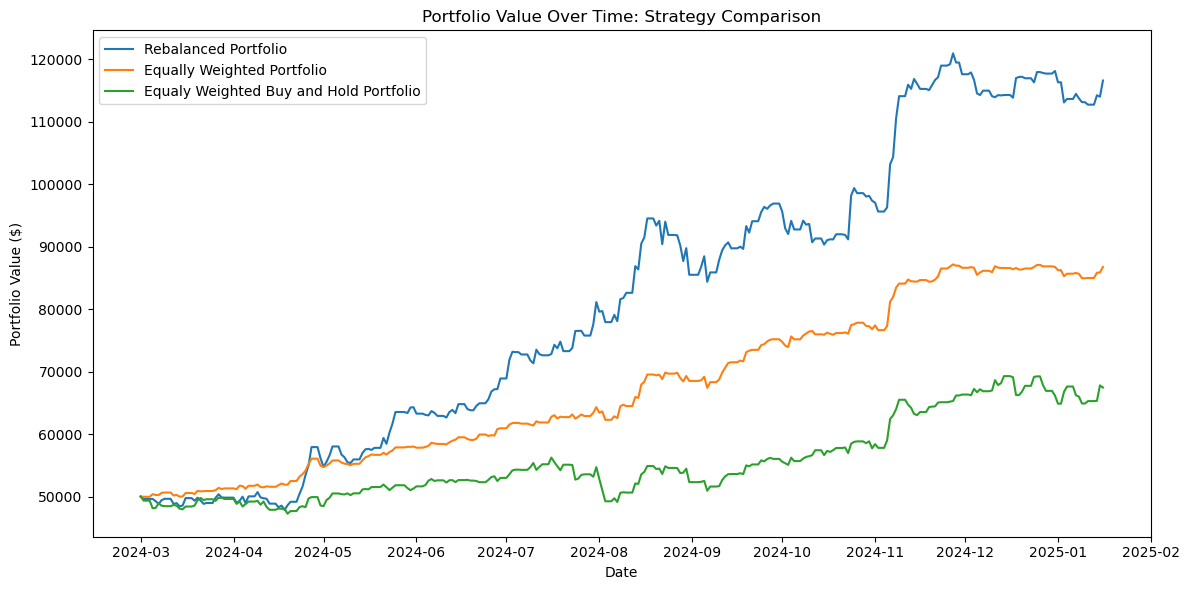

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(portfolio_daily_report.index, portfolio_daily_report['Total_Portfolio_Value'], label='Rebalanced Portfolio')
plt.plot(equally_weighted_report.index, equally_weighted_report['Total_Portfolio_Value'], label='Equally Weighted Portfolio')
plt.plot(equally_weighted_buy_and_hold_report.index, equally_weighted_buy_and_hold_report['Total_Portfolio_Value'], label='Equaly Weighted Buy and Hold Portfolio')

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time: Strategy Comparison')
plt.legend()
plt.tight_layout()
plt.show()
